In [1]:
import pandas as pd 
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.metrics import classification_report,  confusion_matrix, accuracy_score, f1_score,  precision_recall_fscore_support

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer   
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPool1D, Conv1D, Input
from tensorflow.keras import layers

import pickle 

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


# Helper Functions

In [2]:
def import_embeddings(path):
    """
    Loads embeddings from a text file
    """
    import os 
    path_to_glove_file = os.path.join(
      os.path.expanduser("~"), path
    )

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    return embeddings_index


### For visualizing trainning loss and validation loss
import matplotlib.pyplot as plt 
def plot_loss(history):
  hist = pd.DataFrame(history.history)
  plt.plot(hist['mae'], label='training_mae')
  plt.plot(hist['val_mae'], label = 'validation_mae')
  plt.legend()
  plt.ylabel("loss")
  plt.xlabel("epochs")
  plt.show()
  

def make_embedding_matrix(word_index, embedding_dim, embeddings_index):
    """
    Returns embedding matrix
    """
    num_tokens = len(word_index) + 2
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix


def compare(X, y_true, y_preds):
  """
  Returns data frame with the test, actual rating, predicited rating, and rounded predicted rating
  """
  return pd.DataFrame({'Text':X, 
                'Actual Rating':y_true, 
                'Predicted Rating':np.squeeze(y_preds),
                'Rounded Rating':np.round(np.squeeze(y_preds))})
  
def get_f1_weighted(compare_df):
  return f1_score(compare_df['Actual Rating'],compare_df['Rounded Rating'], average='weighted')
    


def get_preds(model, X_dev):
  probs = model.predict(X_dev)
  preds = tf.squeeze(tf.round(probs))
  return preds    

def calc_metrics(y_true, y_pred):

 # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
  model_results = {"accuracy": model_accuracy/100,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}

  return model_results



# Loading and Cleaning

In [3]:
la = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/Los%20Angeles_restaurant.csv")
sd = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/San%20Diego_restaurant.csv")
sf = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/San%20Francisco_restaurant.csv")
oc = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/Orange%20County_restaurant.csv")
at = pd.read_csv('https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/Atalanta_restaurant.csv')
ny = pd.read_csv('https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/New%20York_restaurant.csv')

In [4]:
def clean_name(col):
    if 'http' in col:
        col = col.split('Reviews')[1]
        col = col.split('-')[-2]
        col = col.replace('_',' ')
        return col
    else:
        return col



In [5]:
df = pd.concat([la,sd,ny,oc,sf,at])
df['rating'] = df['rating']/10 
df['restaurant'] = df['restaurant'].apply(lambda x: clean_name(x))
df['restaurant'] = df['restaurant'].apply(lambda x: 'In-N-Out Burger' if 'In N Out' in x else x)
df = df[pd.to_numeric(df['review'], errors='coerce').isnull()]
df = df.dropna(subset=['rating','review'])
df['review'] = df['review'].str.split('..More').str[0]

# Balance dataset 
- Convert Non 5 ratings to 0 and 5 star ratings to 1

In [6]:
df['is_5'] = df['rating'].apply(lambda x: 1 if x==5 else 0)

In [7]:
df['is_5'].value_counts().values[0]/len(df)
## Percentage of 1 in the dataset

0.5527648291090267

In [8]:
df['is_5'].value_counts()

1    585787
0    473953
Name: is_5, dtype: int64

# Splitting Train Test Dev

In [9]:
def train_dev_test_df(df, splits):
    """"
    Takes in a dataframe and splits into train dev and test
    """
    np.random.seed(42)
    shuffle_df = df.sample(frac=1)

    train, dev = splits

    X = shuffle_df['review'].to_numpy()
    y = shuffle_df['is_5'].to_numpy()

    train_cutoff = int(X.shape[0]*train)
    dev_cutoff = int(X.shape[0]*(train+dev))

    X_train = X[:train_cutoff]
    y_train = y[:train_cutoff]

    X_dev = X[train_cutoff:dev_cutoff]
    y_dev = y[train_cutoff:dev_cutoff]

    X_test = X[dev_cutoff:]
    y_test = y[dev_cutoff:]

    y_train = tf.constant(y_train, dtype=tf.int32)
    y_dev = tf.constant(y_dev, dtype = tf.int32)
    y_test = tf.constant(y_test, dtype=tf.int32)

    return X_train, y_train, X_dev, y_dev, X_test, y_test

In [10]:
train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels = train_dev_test_df(df,(.9,.05))

# Converting to Dataset

In [11]:
# x_train = text_vectorizer(np.array([[s] for s in train_sentences])).numpy()
# x_val = text_vectorizer(np.array([[s] for s in val_sentences])).numpy()

In [12]:
train_data = (tf.data.Dataset.from_tensor_slices(
    (train_sentences,
    train_labels)
))

val_data = (tf.data.Dataset.from_tensor_slices(
    (val_sentences,
    val_labels)
))

test_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels))

In [13]:
batch_size=128
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

In [14]:
train_data_repeat = train_data.repeat()
val_data_repeat = val_data.repeat()

# Models

## Baseline Models: Naives Bayes

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [16]:
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

### Results

In [17]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 72.95%


In [18]:
baseline_preds = model_0.predict(val_sentences)

baseline_metrics = calc_metrics(val_labels, baseline_preds)
baseline_metrics

{'accuracy': 0.7294996886028648,
 'f1': 0.7776278023427198,
 'precision': 0.7119197772853815,
 'recall': 0.8566984582777835}

In [19]:
print(classification_report(val_labels, baseline_preds))

              precision    recall  f1-score   support

           0       0.76      0.57      0.65     23734
           1       0.71      0.86      0.78     29253

    accuracy                           0.73     52987
   macro avg       0.74      0.71      0.72     52987
weighted avg       0.74      0.73      0.72     52987



## Deep Models 
---
 - Need to find the Avg and St dev for the amount of words per review

### No pretrain embeddings 

In [20]:
train_sentences_lengths = pd.Series([len(i.split()) for i in train_sentences])

max_length = int(train_sentences_lengths.mean() + train_sentences_lengths.std())
max_vocab_length = 70000

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

text_vectorizer.adapt(train_sentences)

In [ ]:
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

In [ ]:
def train():
  hyperparamters_defaults = dict(epochs=5,
                                batch_size=batch_size,
                                optimizer='adam',
                                loss_function='binary_crossentropy',
                                architecture='LSTM',
                                embed_dim = 256,
                                max_vocab_length=max_vocab_length,
                                 learning_rate=0.001)

  run = wandb.init(project='food_nlp_sweep_5',
                  config = hyperparamters_defaults)

  config = wandb.config

  embedding = Embedding(input_dim=config.max_vocab_length,
                        output_dim=config.embed_dim,
                        embeddings_initializer='uniform',
                        input_length = max_length)

  inputs = Input(shape=(1,), dtype='string')

  x = text_vectorizer(inputs)

  x = embedding(x)
  x = Bidirectional(LSTM(config.lstm_units, return_sequences=True))(x) 
  x = Dropout(0.4)(x)
  x = Bidirectional(LSTM(config.lstm_units))(x) 
  x = Dropout(0.4)(x)
  
  x = Dense(config.dense_units, activation='relu')(x)

  outputs = Dense(1, activation="sigmoid")(x)

  model_1 = tf.keras.Model(inputs, outputs, name="model_1_LSTM")
  model_1.summary()

  METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')] 

  model_1.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=METRICS)
  
  model_1.fit(train_data_repeat,    ## repeat data set required when the steps per epoch does not equal the total number of batches
            epochs=config.epochs,
            steps_per_epoch=int(0.2*len(train_data)),
            validation_data = val_data_repeat,
            validation_steps = int(0.2*len(val_data)),
            callbacks=[WandbCallback(save_weights_only=True)])

  model_1.fit(train_data,steps_per_epoch=len(train_data))
 
  model_1_preds = get_preds(model_1, val_data)
  model_1_metrics = calc_metrics(val_labels, model_1_preds)

  wandb.log(model_1_metrics)

  

In [ ]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'dense_units': {
            'values': [8,16,32,64,128,256]
        },
         'lstm_units': {
            'values' : [8,16,32,64,128,256]
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='food_nlp_sweep_5')        

#### Training

In [ ]:
wandb.agent(sweep_id, function=train)

### Pretrained Embeddings 

In [21]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-07-20 16:46:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-20 16:46:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-20 16:46:01--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [22]:
voc = text_vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [23]:
embeddings_100 = import_embeddings('/content/glove.6B.100d.txt')
embeddings_200 = import_embeddings('/content/glove.6B.200d.txt')
embeddings_300 = import_embeddings('/content/glove.6B.300d.txt')


## makes embedding matrix with token vectors
embedding_matrix_100 = make_embedding_matrix(word_index,100, embeddings_100)
embedding_matrix_200 = make_embedding_matrix(word_index,200, embeddings_200)
embedding_matrix_300 = make_embedding_matrix(word_index,300, embeddings_300)


Found 400000 word vectors.
Found 400000 word vectors.
Found 400000 word vectors.
Converted 40585 words (29415 misses)
Converted 40585 words (29415 misses)
Converted 40585 words (29415 misses)


#### LSTM

In [ ]:
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'learning_rate': {
            'values': np.logspace(-2,-4, num=5).tolist()
        },
         'dropout_rate': {
            'values' : [0.2, 0.4, 0.6, 0.8]
        },
          'dense_units': {
            'values' : [8, 32, 64, 128, 256]
          },
          'embed_dim': {
              'values' : [100,200,300]
          }
    }
}

In [ ]:
def train_lstm():
  hyperparamters_defaults = dict(epochs=9,
                                batch_size=batch_size,
                                optimizer='adam',
                                loss_function='binary_crossentropy',
                                architecture='LSTM',
                                max_vocab_length=70000)

  run = wandb.init(project='food_nlp_sweep_1',
                  config = hyperparamters_defaults)


  config = wandb.config

  ## for sweep to select embedding 
  embedding_dic = {100:embedding_matrix_100, 200:embedding_matrix_200, 300:embedding_matrix_300}
  embedding_matrix = embedding_dic[config.embed_dim]

  max_vocab, embed_dim = embedding_matrix.shape

  embedding = Embedding(max_vocab,
                      embed_dim,
                      tf.keras.initializers.Constant(embedding_matrix),
                      trainable=False)

  inputs = Input(shape=(1,), dtype='string')
  x = text_vectorizer(inputs)

  x = embedding(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
  x = Bidirectional(LSTM(64))(x) 
  x = Dropout(config.dropout_rate)(x)
  x = Dense(config.dense_units, activation='relu')(x)
  x = Dropout(config.dropout_rate)(x)
  outputs = Dense(1, activation="sigmoid")(x)

  model = tf.keras.Model(inputs, outputs, name="model_1_LSTM")


  METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')] 

  model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
                  metrics=METRICS)
    
  model.summary()

  model.fit(train_data_repeat,    ## repeat data set required when the steps per epoch does not equal the total number of batches
            epochs=config.epochs,
            steps_per_epoch=int(0.2*len(train_data)),
            validation_data = val_data_repeat,
            validation_steps = int(0.2*len(val_data)),
            callbacks=[WandbCallback()])

  model.fit(train_data,
            steps_per_epoch=len(train_data))

  model_preds = get_preds(model, val_data)
  metrics = calc_metrics(val_labels, model_preds)

  wandb.log(metrics)

In [ ]:
# sweep_id = wandb.sweep(sweep_config, project='food_nlp_sweep_3')        

Create sweep with ID: vvpkvg0a
Sweep URL: https://wandb.ai/jacobh0830/food_nlp_sweep_3/sweeps/vvpkvg0a


##### Training

In [ ]:
wandb.agent('vvpkvg0a',  project='food_nlp_sweep_3' ,function=train_lstm)

#### CONV1D

In [ ]:
sweep_config = {
    'method': 'grid',
    'parameters': {
         'dropout_rate': {
            'values' : [0.2, 0.4, 0.6]
        },
          'dense_units': {
            'values' : [64, 128, 256]
          },
          'kernel_size': {
              'values' : [3,5]
          },
            'filters': {
              'values' : [8,32,64,128,256]
          },
          'pool_size': {
              'values' : [3,5]
          }
    }
}

In [ ]:
def train_conv1d():  
  hyperparamters_defaults = dict(epochs=9,
                                batch_size=batch_size,
                                optimizer='adam',
                                loss_function='binary_crossentropy',
                                architecture='CONV1D',
                                max_vocab_length=70000,
                                embedding_dimension=300,
                                 learning_rate=0.001)

  run = wandb.init(project='food_nlp_sweep_4',
                  config = hyperparamters_defaults)


  config = wandb.config

  max_vocab, embed_dim = embedding_matrix_300.shape

  embedding = Embedding(max_vocab,
                      embed_dim,
                      embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix_300),
                      trainable=False)

  inputs = Input(shape=(1,), dtype='string')

  x = text_vectorizer(inputs)

  x = embedding(x)
  x = layers.Conv1D(config.filters, config.kernel_size, activation="relu")(x)
  x = layers.MaxPooling1D(config.pool_size)(x)

  x = layers.Conv1D(config.filters, config.kernel_size, activation="relu")(x)
  x = layers.GlobalMaxPooling1D()(x)

  x = layers.Dense(128, activation="relu")(x)
  x = layers.Dropout(config.dropout_rate)(x)

  outputs = Dense(1, activation="sigmoid")(x)

  model_conv = tf.keras.Model(inputs, outputs, name="model_CONV1D")


  METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')] 

  model_conv.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=METRICS)
    
  model_conv.summary()

  model_conv.fit(train_data_repeat,
                            epochs = config.epochs,
                            steps_per_epoch=int(0.2*len(train_data)),
                            validation_data = val_data_repeat,
                            validation_steps = int(0.2*len(val_data)),
                            callbacks=[WandbCallback()])

  model_conv.fit(train_data,
                steps_per_epoch=len(train_data))

  model_conv_preds = get_preds(model_conv, val_data)
  metrics = calc_metrics(val_labels, model_conv_preds)

  wandb.log(metrics)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='food_nlp_sweep_4')        

Create sweep with ID: k8e32ghs
Sweep URL: https://wandb.ai/jacobh0830/food_nlp_sweep_4/sweeps/k8e32ghs


##### Training

In [ ]:
wandb.agent(sweep_id, function=train_conv1d)

# Best Models from hyperparamter sweeps

In [24]:
sweep1 = pd.read_csv('https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_cleaning_exploration_model_building/wandb_sweep1.csv')
sweep2 = pd.read_csv('https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_cleaning_exploration_model_building/wandb_sweep2.csv')
sweep3 = pd.read_csv('https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_cleaning_exploration_model_building/wandb_sweep3.csv')
sweep4 = pd.read_csv('https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_cleaning_exploration_model_building/wandb_sweep4.csv')
sweep5 = pd.read_csv('https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_cleaning_exploration_model_building/wandb_sweep5.csv')

## Best Params from sweep 1 
---
- Architecture = LSTM
- 128 embedding dimensions
- Optimizer: Adam
- Max Vocab 20000
- No Pretrained Embeddings

In [25]:
sweep1[['val_accuracy','learning_rate','dropout_rate']].head(3)

,val_accuracy,learning_rate,dropout_rate
0,0.769909,0.000518,0.2
1,0.769657,0.000518,0.8
2,0.768775,0.001931,0.8


## Best Params from sweep 2 
---
- Architecture = LSTM
- 128 embedding dimensions
- Optimizer: Adam
- Max Vocab 50000
- No Pretrained Embeddings

In [26]:
sweep2[['val_accuracy','learning_rate','dropout_rate']].head(3)

,val_accuracy,learning_rate,dropout_rate
0,0.770917,0.001668,0.4
1,0.765877,0.000599,0.4
2,0.769279,0.000599,0.2


## Best Params from sweep 3 
---
- Architecture = LSTM
- Optimizer: Adam
- Max Vocab 70000
- Pre-trained Embeddings

In [27]:
sweep3[['val_accuracy','learning_rate','dropout_rate','embed_dim','dense_units']].sort_values('val_accuracy', ascending=False).head()

,val_accuracy,learning_rate,dropout_rate,embed_dim,dense_units
89,0.773533,0.003162,0.2,200,64
1,0.773342,0.003162,0.2,300,128
3,0.772485,0.001000,0.2,300,8
14,0.772294,0.003162,0.2,300,32
2,0.772294,0.001000,0.2,300,128


## Best Params from sweep 4
---
- Architecture = CONV1D
- Optimizer: Adam
- Max Vocab 70000
- Embedding dimension:300
- Pre-trained Embeddings

In [28]:
sweep4[['val_accuracy','dropout_rate','filters','kernel_size','pool_size']].sort_values('val_accuracy', ascending=False).head()

,val_accuracy,dropout_rate,filters,kernel_size,pool_size
0,0.770198,0.4,256,3,3
18,0.769531,0.6,256,3,5
147,0.768960,0.2,256,3,5
105,0.768293,0.2,128,3,3
3,0.767721,0.2,256,3,3


## Best Params from sweep 5
---
- Architecture = LSTM
- Optimizer: Adam
- Max Vocab 70000
- Embedding dimension: 
- No Pretrained Embeddings

In [29]:
sweep5[['val_accuracy','dense_units','lstm_units']].sort_values('val_accuracy', ascending=False).head()

,val_accuracy,dense_units,lstm_units
31,0.777820,256,16
4,0.777344,256,128
21,0.776677,8,64
9,0.776582,64,128
26,0.776391,16,16


# Trainning on whole data set

## Callbacks

In [30]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3)

checkpoint_path_no_embeddings = "lstm_noembed_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_no_embeddings,
                                                      save_best_only=True,
                                                      monitor="val_loss")

## Best LSTM
---
- No pretrained embeddings
- 256 embedding size 


In [31]:
embedding = Embedding(input_dim=max_vocab_length,
                      output_dim=256,
                      embeddings_initializer='uniform',
                      input_length = max_length)

inputs = Input(shape=(1,), dtype='string')

x = text_vectorizer(inputs)

x = embedding(x)
x = Bidirectional(LSTM(256, return_sequences=True))(x) 
x = Dropout(0.4)(x)
x = Bidirectional(LSTM(256))(x) 
x = Dropout(0.4)(x)

x = Dense(64, activation='relu')(x)

outputs = Dense(1, activation="sigmoid")(x)

model_lstm_no_pretrain= tf.keras.Model(inputs, outputs, name="model_1_LSTM")
model_lstm_no_pretrain.summary()

METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')] 

model_lstm_no_pretrain.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=METRICS)

model_lstm_no_pretrain.fit(train_data,    ## repeat data set required when the steps per epoch does not equal the total number of batches
          epochs=5,
          steps_per_epoch=len(train_data),
          validation_data = val_data,
          validation_steps = len(val_data),
          callbacks=[model_checkpoint, reduce_lr])


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 512)           1050624   
_________________________________________________________________
dropout (Dropout)            (None, 60, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

INFO:tensorflow:Assets written to: lstm_noembed_checkpoints/assets


INFO:tensorflow:Assets written to: lstm_noembed_checkpoints/assets


Epoch 2/5
7452/7452 [==============================] - 892s 120ms/step - loss: 0.4355 - accuracy: 0.7902 - precision: 0.7869 - recall: 0.8511 - val_loss: 0.4595 - val_accuracy: 0.7775 - val_precision: 0.7629 - val_recall: 0.8663
Epoch 3/5
7452/7452 [==============================] - 888s 119ms/step - loss: 0.3882 - accuracy: 0.8175 - precision: 0.8142 - recall: 0.8680 - val_loss: 0.5004 - val_accuracy: 0.7712 - val_precision: 0.7693 - val_recall: 0.8364

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/5
7452/7452 [==============================] - 888s 119ms/step - loss: 0.3182 - accuracy: 0.8546 - precision: 0.8497 - recall: 0.8953 - val_loss: 0.6530 - val_accuracy: 0.7578 - val_precision: 0.7710 - val_recall: 0.7984
Epoch 5/5
7452/7452 [==============================] - 889s 119ms/step - loss: 0.2864 - accuracy: 0.8700 - precision: 0.8652 - recall: 0.9061 - val_loss: 0.7543 - val_accuracy: 0.7508 - val_precision: 0.7668 - val_recall: 0.7882

E

In [32]:
model_lstm_no_pretrain.load_weights(checkpoint_path_no_embeddings)
model_lstm_no_pretrain.evaluate(val_data)

414/414 [==============================] - 8s 19ms/step - loss: 0.4583 - accuracy: 0.7770 - precision: 0.7727 - recall: 0.8444


[0.45830971002578735,
 0.7769830226898193,
 0.7727272510528564,
 0.8443920016288757]

In [33]:
model_lstm_no_pretrain_preds = get_preds(model_lstm_no_pretrain, val_data)
model_lstm_no_pretrain_metrics = calc_metrics(val_labels, model_lstm_no_pretrain_preds)
model_lstm_no_pretrain_metrics

{'accuracy': 0.7769830335742729,
 'f1': 0.8069716917950309,
 'precision': 0.7727272727272727,
 'recall': 0.8443920281680511}

# Fine Tuning 
---
- Taking the best paramters for each architecture and fine tuning the pretraianed embeddings

## Conv1D

In [34]:
checkpoint_path_conv = "conv_checkpoints/"
model_checkpoint_conv = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_conv,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [35]:
max_vocab, embed_dim = embedding_matrix_300.shape

embedding = Embedding(max_vocab,
                    embed_dim,
                    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix_300),
                    trainable=False)

inputs = Input(shape=(1,), dtype='string')

x = text_vectorizer(inputs)

x = embedding(x)
x = layers.Conv1D(256, 3, activation="relu")(x)
x = layers.MaxPooling1D(3)(x)

x = layers.Conv1D(256, 3 , activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)

x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)

outputs = Dense(1, activation="sigmoid")(x)

model_conv = tf.keras.Model(inputs, outputs, name="model_CONV1D")


METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')] 

model_conv.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=METRICS)
  
model_conv.summary()

model_conv.fit(train_data,
                epochs = 5,
                steps_per_epoch=len(train_data),
                validation_data = val_data_repeat,
                validation_steps = int(0.2*len(val_data)),
               callbacks=[model_checkpoint_conv, reduce_lr])




Model: "model_CONV1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 60)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 60, 300)           21000600  
_________________________________________________________________
conv1d (Conv1D)              (None, 58, 256)           230656    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17, 256)           196864    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)              

INFO:tensorflow:Assets written to: conv_checkpoints/assets


Epoch 2/5
7452/7452 [==============================] - 71s 10ms/step - loss: 0.4710 - accuracy: 0.7706 - precision: 0.7665 - recall: 0.8412 - val_loss: 0.4849 - val_accuracy: 0.7661 - val_precision: 0.7437 - val_recall: 0.8787
INFO:tensorflow:Assets written to: conv_checkpoints/assets


INFO:tensorflow:Assets written to: conv_checkpoints/assets


Epoch 3/5
7452/7452 [==============================] - 71s 10ms/step - loss: 0.4520 - accuracy: 0.7812 - precision: 0.7746 - recall: 0.8522 - val_loss: 0.4815 - val_accuracy: 0.7679 - val_precision: 0.7493 - val_recall: 0.8702
INFO:tensorflow:Assets written to: conv_checkpoints/assets


INFO:tensorflow:Assets written to: conv_checkpoints/assets


Epoch 4/5
7452/7452 [==============================] - 72s 10ms/step - loss: 0.4363 - accuracy: 0.7894 - precision: 0.7807 - recall: 0.8607 - val_loss: 0.4895 - val_accuracy: 0.7701 - val_precision: 0.7551 - val_recall: 0.8630
Epoch 5/5
7452/7452 [==============================] - 71s 10ms/step - loss: 0.4215 - accuracy: 0.7971 - precision: 0.7862 - recall: 0.8692 - val_loss: 0.4898 - val_accuracy: 0.7651 - val_precision: 0.7395 - val_recall: 0.8860

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


In [36]:
model_conv.load_weights(checkpoint_path_conv)
model_conv_preds_prefinetune = get_preds(model_conv, val_data)
metrics_conv_prefinetune = calc_metrics(val_labels, model_conv_preds_prefinetune)
metrics_conv_prefinetune

{'accuracy': 0.7676599920735273,
 'f1': 0.8059456818145995,
 'precision': 0.7477769977769978,
 'recall': 0.8739274604314088}

In [ ]:
# model_conv.save_weights('conv_weights')
# model_conv.load_weights('conv_weights')

In [37]:
checkpoint_path_conv_finetune = "conv_finetune_checkpoints/"
model_checkpoint_conv_finetune = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_conv_finetune,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [38]:
embedding.trainable = True

model_conv.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=METRICS)

In [39]:
finetune_epochs = 2

history_model_conv_fintune = model_conv.fit(train_data,
                                          epochs = finetune_epochs,
                                          steps_per_epoch=len(train_data),
                                          validation_data = val_data_repeat,
                                          validation_steps = int(0.2*len(val_data)),
                                          callbacks=[model_checkpoint_conv_finetune])

Epoch 1/2
7452/7452 [==============================] - 894s 120ms/step - loss: 0.4109 - accuracy: 0.8022 - precision: 0.7943 - recall: 0.8665 - val_loss: 0.5037 - val_accuracy: 0.7660 - val_precision: 0.7647 - val_recall: 0.8315
INFO:tensorflow:Assets written to: conv_finetune_checkpoints/assets


INFO:tensorflow:Assets written to: conv_finetune_checkpoints/assets


Epoch 2/2
7452/7452 [==============================] - 851s 114ms/step - loss: 0.3827 - accuracy: 0.8177 - precision: 0.8082 - recall: 0.8787 - val_loss: 0.5416 - val_accuracy: 0.7634 - val_precision: 0.7696 - val_recall: 0.8150


In [40]:
model_conv.load_weights(checkpoint_path_conv_finetune)
model_conv_preds_post_finetune = get_preds(model_conv, val_data)
metrics_conv_post_finetune = calc_metrics(val_labels, model_conv_preds_post_finetune)
metrics_conv_post_finetune

{'accuracy': 0.7666974918376206,
 'f1': 0.7981977864115708,
 'precision': 0.7638806436494298,
 'recall': 0.835743342563156}

## LSTM

In [41]:
checkpoint_path_lstm = "lstm_prefine_checkpoints/"
model_checkpoint_lstm = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_lstm,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [42]:
embedding_dic = {100:embedding_matrix_100, 200:embedding_matrix_200, 300:embedding_matrix_300}
embedding_matrix = embedding_dic[300]

max_vocab, embed_dim = embedding_matrix.shape

embedding = Embedding(max_vocab,
                    embed_dim,
                    tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False)

inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)

x = embedding(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x) 
x = Bidirectional(LSTM(64))(x) 
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation="sigmoid")(x)

lstm_model = tf.keras.Model(inputs, outputs, name="model_1_LSTM")


METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')] 

lstm_model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0031),
                metrics=METRICS)
  
lstm_model.summary()

lstm_model.fit(train_data,    ## repeat data set required when the steps per epoch does not equal the total number of batches
          epochs=5,
          steps_per_epoch=len(train_data),
          validation_data = val_data_repeat,
          validation_steps = int(0.2*len(val_data)),
          callbacks=[model_checkpoint_lstm, reduce_lr])



Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 60)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 60, 300)           21000600  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 128)           186880    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

INFO:tensorflow:Assets written to: lstm_prefine_checkpoints/assets


INFO:tensorflow:Assets written to: lstm_prefine_checkpoints/assets


Epoch 2/5
7452/7452 [==============================] - 159s 21ms/step - loss: 0.4609 - accuracy: 0.7765 - precision: 0.7733 - recall: 0.8426 - val_loss: 0.4678 - val_accuracy: 0.7736 - val_precision: 0.7603 - val_recall: 0.8609


INFO:tensorflow:Assets written to: lstm_prefine_checkpoints/assets


INFO:tensorflow:Assets written to: lstm_prefine_checkpoints/assets


Epoch 3/5
7452/7452 [==============================] - 159s 21ms/step - loss: 0.4457 - accuracy: 0.7850 - precision: 0.7801 - recall: 0.8509 - val_loss: 0.4596 - val_accuracy: 0.7760 - val_precision: 0.7629 - val_recall: 0.8616


INFO:tensorflow:Assets written to: lstm_prefine_checkpoints/assets


INFO:tensorflow:Assets written to: lstm_prefine_checkpoints/assets


Epoch 4/5
7452/7452 [==============================] - 160s 21ms/step - loss: 0.4355 - accuracy: 0.7905 - precision: 0.7850 - recall: 0.8554 - val_loss: 0.4618 - val_accuracy: 0.7775 - val_precision: 0.7650 - val_recall: 0.8611
Epoch 5/5
7452/7452 [==============================] - 159s 21ms/step - loss: 0.4287 - accuracy: 0.7943 - precision: 0.7886 - recall: 0.8579 - val_loss: 0.4593 - val_accuracy: 0.7794 - val_precision: 0.7627 - val_recall: 0.8711


INFO:tensorflow:Assets written to: lstm_prefine_checkpoints/assets


INFO:tensorflow:Assets written to: lstm_prefine_checkpoints/assets


In [43]:
lstm_model.load_weights(checkpoint_path_lstm)
model_lstm_preds_prefinetune = get_preds(lstm_model, val_data)
metrics_lstm_prefinetune = calc_metrics(val_labels, model_lstm_preds_prefinetune)
metrics_lstm_prefinetune

{'accuracy': 0.7762847490893993,
 'f1': 0.8109771654547774,
 'precision': 0.7600047819719656,
 'recall': 0.8692783646121766}

In [44]:
checkpoint_path_lstm_finetune = "lstm_finetune_checkpoints/"
model_checkpoint_lstm_finetune= tf.keras.callbacks.ModelCheckpoint(checkpoint_path_lstm_finetune,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [45]:
embedding.trainable = True

lstm_model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=METRICS)

history_model_lstm_fintune = lstm_model.fit(train_data,
                                          epochs = 2,
                                          steps_per_epoch=len(train_data),
                                          validation_data = val_data_repeat,
                                          validation_steps = int(0.2*len(val_data)),
                                          callbacks=[model_checkpoint_lstm_finetune])

Epoch 1/2
7452/7452 [==============================] - 910s 122ms/step - loss: 0.4060 - accuracy: 0.8055 - precision: 0.8002 - recall: 0.8637 - val_loss: 0.4809 - val_accuracy: 0.7791 - val_precision: 0.7773 - val_recall: 0.8400


INFO:tensorflow:Assets written to: lstm_finetune_checkpoints/assets


INFO:tensorflow:Assets written to: lstm_finetune_checkpoints/assets


Epoch 2/2
7452/7452 [==============================] - 904s 121ms/step - loss: 0.3800 - accuracy: 0.8205 - precision: 0.8148 - recall: 0.8740 - val_loss: 0.4991 - val_accuracy: 0.7764 - val_precision: 0.7771 - val_recall: 0.8336


In [46]:
lstm_model.load_weights(checkpoint_path_lstm_finetune)
model_lstm_preds_finetune = get_preds(lstm_model, val_data)
metrics_lstm_finetune = calc_metrics(val_labels, model_lstm_preds_finetune)
metrics_lstm_finetune

{'accuracy': 0.7795119557627342,
 'f1': 0.8086604759331139,
 'precision': 0.7762057473432685,
 'recall': 0.8439476293029775}

# Hybrid

In [ ]:
! pip install vaderSentiment

In [48]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()



In [49]:
train_sents = [analyzer.polarity_scores(train_sentences[i]) for i in range(len(train_sentences))]
val_sents = [analyzer.polarity_scores(val_sentences[i]) for i in range(len(val_sentences))]

In [50]:
train_sents_df = pd.DataFrame(train_sents).astype('float32')
val_sents_df = pd.DataFrame(val_sents).astype('float32')

In [51]:
train_sents_data = tf.data.Dataset.from_tensor_slices((train_sents_df.drop(columns='compound'), train_labels))
val_sents_data = tf.data.Dataset.from_tensor_slices((val_sents_df.drop(columns='compound'), val_labels))

In [52]:
batch_size=128
train_sents_data = train_sents_data.shuffle(buffer_size=1000).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_sents_data = val_sents_data.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

## Combining Data

In [53]:
batch_size = 128

train_combined_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_sents_df.drop(columns='compound')))
train_combined_labels = tf.data.Dataset.from_tensor_slices(train_labels)
train_combined_dataset =   tf.data.Dataset.zip((train_combined_data, train_combined_labels))
train_combined_dataset = train_combined_dataset.shuffle(buffer_size=1000).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


val_combined_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_sents_df.drop(columns='compound')))
val_combined_labels = tf.data.Dataset.from_tensor_slices(val_labels)
val_combined_dataset =   tf.data.Dataset.zip((val_combined_data, val_combined_labels))
val_combined_dataset = val_combined_dataset.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

In [54]:
train_combined_dataset_repeat = train_combined_dataset.repeat()
val_combined_dataset_repeat = val_combined_dataset.repeat()

In [55]:
# lstm model
embedding_dic = {100:embedding_matrix_100, 200:embedding_matrix_200, 300:embedding_matrix_300}
embedding_matrix = embedding_dic[300]

max_vocab, embed_dim = embedding_matrix.shape

embedding = Embedding(max_vocab,
                    embed_dim,
                    tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False)

lstm_inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(lstm_inputs)

x = embedding(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x) 
x = Bidirectional(LSTM(64))(x) 
x = Dropout(0.6)(x)
x = Dense(8, activation='relu')(x)
x = Dropout(0.6)(x)

lstm_model_1 = tf.keras.Model(inputs=lstm_inputs,
                            outputs =x)


# vader sentiment model
sent_inputs = Input(shape=(3,), dtype=tf.float32, name='input_layer')
x = Dense(32, activation='relu')(sent_inputs)
x = Dense(16, activation='relu')(x)
model_sents = tf.keras.Model(inputs= sent_inputs,
                             outputs=x)
## Cocatenate

sent_lstm_concat = layers.Concatenate(name='concat_layer')([lstm_model_1.output, model_sents.output])
concat_output = Dense(1, activation='sigmoid')(sent_lstm_concat)

sent_lstm_model = tf.keras.Model(inputs=[lstm_model_1.input, model_sents.input],
                                 outputs=concat_output)

sent_lstm_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 60)           0           input_4[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 60, 300)      21000600    text_vectorization[3][0]         
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 60, 128)      186880      embedding_3[0][0]                
____________________________________________________________________________________________

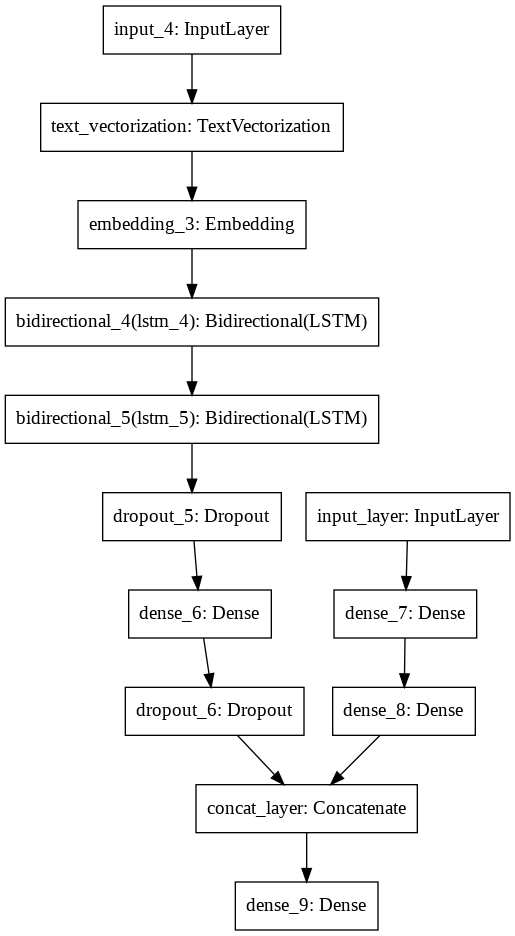

In [56]:
from tensorflow.keras.utils import plot_model
plot_model(sent_lstm_model)

In [57]:
METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')] 

sent_lstm_model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=METRICS)

In [58]:
sent_lstm_model.fit(train_combined_dataset_repeat, 
                    epochs=10,
                    steps_per_epoch=int(0.2*len(train_combined_dataset)),
                    validation_data=val_combined_dataset_repeat,
                    validation_steps=int(0.2*len(val_combined_dataset)))

Epoch 1/10
1490/1490 [==============================] - 42s 25ms/step - loss: 0.5858 - accuracy: 0.6870 - precision: 0.6866 - recall: 0.8003 - val_loss: 0.5286 - val_accuracy: 0.7273 - val_precision: 0.7138 - val_recall: 0.8440
Epoch 2/10
1490/1490 [==============================] - 34s 23ms/step - loss: 0.5522 - accuracy: 0.7159 - precision: 0.7116 - recall: 0.8168 - val_loss: 0.5240 - val_accuracy: 0.7338 - val_precision: 0.7720 - val_recall: 0.7341
Epoch 3/10
1490/1490 [==============================] - 34s 23ms/step - loss: 0.5389 - accuracy: 0.7255 - precision: 0.7193 - recall: 0.8278 - val_loss: 0.5012 - val_accuracy: 0.7479 - val_precision: 0.7267 - val_recall: 0.8701
Epoch 4/10
1490/1490 [==============================] - 34s 23ms/step - loss: 0.5310 - accuracy: 0.7308 - precision: 0.7231 - recall: 0.8293 - val_loss: 0.5011 - val_accuracy: 0.7438 - val_precision: 0.7169 - val_recall: 0.8849
Epoch 5/10
1490/1490 [==============================] - 34s 23ms/step - loss: 0.5268 - a

In [59]:
hybrid_model_preds = get_preds(sent_lstm_model, val_combined_dataset)
hybrid_results = calc_metrics(val_labels, hybrid_model_preds)
hybrid_results

{'accuracy': 0.7695095023307603,
 'f1': 0.7985816772491136,
 'precision': 0.7714932126696833,
 'recall': 0.8276416094075821}

# Evaluation on Validation Data

## Compare Results

In [63]:
compare_results = pd.DataFrame({'baseline':baseline_metrics,
                                'lstm_no_pretraining':model_lstm_no_pretrain_metrics,
                                'lstm_prefinetune':metrics_conv_prefinetune,
                                'lstm_finetine':metrics_lstm_finetune,
                                'conv1D_prefinetune':metrics_conv_prefinetune,
                                'conv1D_fintune':metrics_conv_post_finetune,
                                'lstm_hyrbid':hybrid_results})
compare_results = compare_results.T
compare_results

,accuracy,precision,recall,f1
baseline,0.729632,0.712146,0.856459,0.777664
lstm_no_pretraining,0.778115,0.766334,0.860459,0.810673
lstm_prefinetune,0.768434,0.754457,0.860664,0.804069
lstm_finetine,0.780984,0.775991,0.848118,0.810453
conv1D_prefinetune,0.768434,0.754457,0.860664,0.804069
conv1D_fintune,0.770736,0.764382,0.845281,0.802799
lstm_hyrbid,0.758714,0.729679,0.894233,0.803619


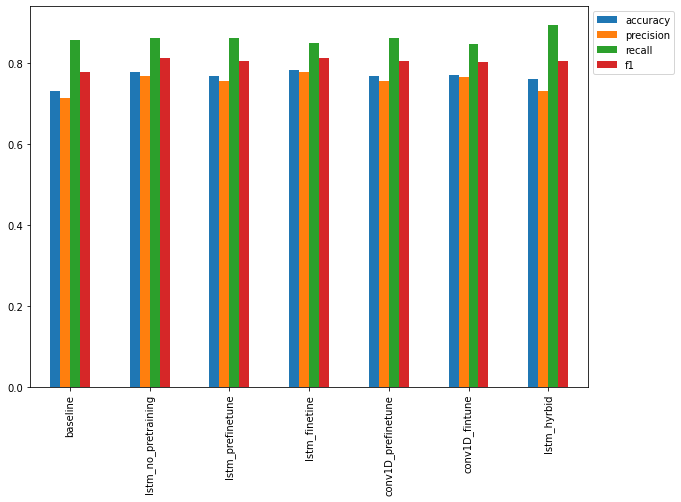

In [64]:
compare_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


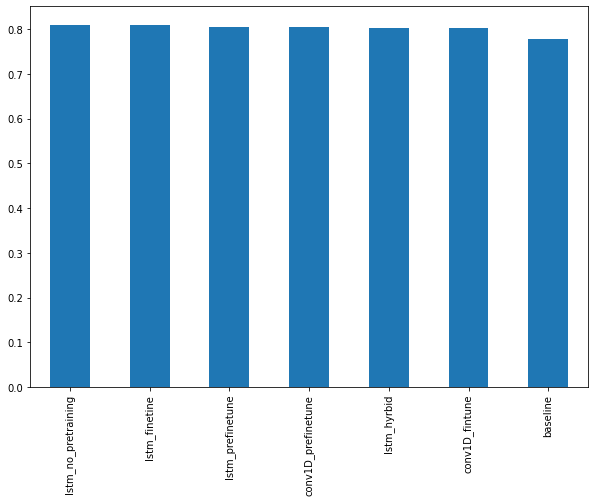

In [65]:
compare_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));


In [66]:
compare_results.sort_values("f1", ascending=False)[["f1"]]

,f1
lstm_no_pretraining,0.810673
lstm_finetine,0.810453
lstm_prefinetune,0.804069
conv1D_prefinetune,0.804069
lstm_hyrbid,0.803619
conv1D_fintune,0.802799
baseline,0.777664


## Confusion Matrix

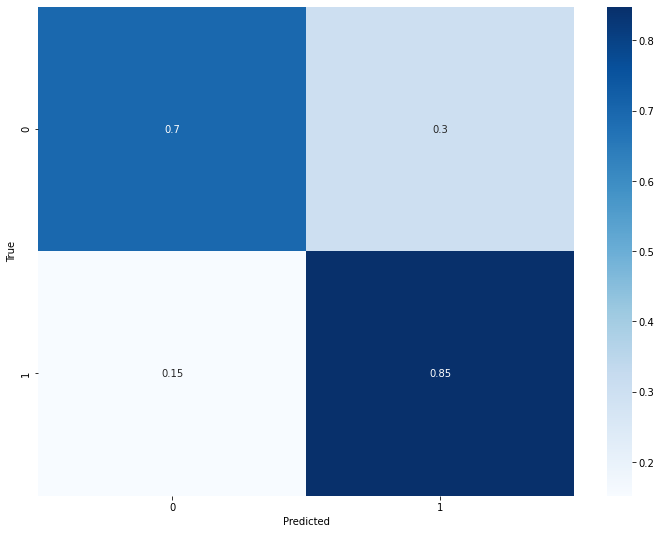

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sn 

cm = confusion_matrix(y_true=val_labels, y_pred= model_lstm_preds_finetune)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12,9))
sn.heatmap(cm_norm,annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation on Test Data

In [96]:
test_model_lstm_preds_finetune = get_preds(lstm_model, test_data)
test_model_lstm_no_pretrain_preds = get_preds(model_lstm_no_pretrain, test_data)


In [97]:
test_model_lstm_finetune_metrics = calc_metrics(test_labels, test_model_lstm_preds_finetune)
test_model_lstm_no_pretrain_metrics = calc_metrics(test_labels, test_model_lstm_no_pretrain_preds)
test_results = pd.DataFrame({'lstm_finetune':test_model_lstm_finetune_metrics,
                             'lstm_no_pretrain': test_model_lstm_no_pretrain_metrics})
test_results = test_results.T
test_results

,accuracy,precision,recall,f1
lstm_finetune,0.780267,0.780981,0.837175,0.808102
lstm_no_pretrain,0.775417,0.764091,0.858758,0.808663


# Saving Model

In [95]:
lstm_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/lstm_finetune",
                           custom_objects={"TextVectorization": TextVectorization})


## Remving Text vecorization layer out of model 

In [ ]:
model = keras.Sequential()

for layer in lstm_model.layers[2:]:
  model.add(layer)


METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')] 

model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=METRICS)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  21000600  
_________________________________________________________________
bidirectional (Bidirectional multiple                  186880    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/lstm_finetune_novec.h5')

time: 24.3 s (started: 2021-07-18 03:00:04 +00:00)


In [ ]:
## Saves vectorizer as a pickle file
pickle.dump({'config': text_vectorizer.get_config(),
             'weights': text_vectorizer.get_weights()}
            , open("tv_layer.pkl", "wb"))

In [ ]:
# loads vectorizer from picke file 
from_disk = pickle.load(open("tv_layer.pkl", "rb"))
loaded_vectorizer = TextVectorization.from_config(from_disk['config'])
loaded_vectorizer.set_weights(from_disk['weights'])

In [ ]:
!pip install ipython-autotime
%load_ext autotime

In [ ]:
import pickle
# new_loaded = tf.keras.models.load_model('lstm_finetune_novec.h5')
new_loaded = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/lstm_finetune_novec.h5')

# loads vectorizer from pickle file
from_disk = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/tv_layer.pkl", "rb"))
loaded_vectorizer = TextVectorization.from_config(from_disk['config'])
loaded_vectorizer.set_weights(from_disk['weights'])

# vecotirze sentence
x_vec = loaded_vectorizer(np.array([val_sentences[0]]))

new_loaded.predict(x_vec)

array([[0.9994585]], dtype=float32)

time: 9.93 s (started: 2021-07-19 00:03:38 +00:00)


In [ ]:
import pickle
import concurrent.futures

def load_vectorizer(path):
  from_disk = pickle.load(open(path, "rb"))
  loaded_vectorizer = TextVectorization.from_config(from_disk['config'])
  loaded_vectorizer.set_weights(from_disk['weights'])
  return loaded_vectorizer
path = "/content/drive/MyDrive/Colab Notebooks/tv_layer.pkl"

with concurrent.futures.ThreadPoolExecutor() as executor:
  f1 = executor.submit(tf.keras.models.load_model, '/content/drive/MyDrive/Colab Notebooks/lstm_finetune_novec.h5')
  f2 = executor.submit(load_vectorizer, path)
  new_loaded = f1.result()
  loaded_vectorizer = f2.result()


# vecotirze sentence
x_vec = loaded_vectorizer(np.array([val_sentences[0]]))

new_loaded.predict(x_vec)

In [ ]:
lstm_model.predict(np.array([val_sentences[0]]))

array([[0.9994585]], dtype=float32)

time: 70.4 ms (started: 2021-07-18 20:46:23 +00:00)


In [ ]:
x_vec = loaded_vectorizer(np.array([val_sentences[0]]))

new_loaded.predict(x_vec)

array([[0.9994585]], dtype=float32)

time: 59.6 ms (started: 2021-07-18 20:48:19 +00:00)


In [ ]:
val_sentences[0]

'If you love Mexican food, a casual ambiance, and great service...This is the place to visit.  Location-in the heart of downtown San Diego...This is my 5th or 6th time I have had lunch at La Puerta. I will continue to visit because I really am...More'

time: 2.98 ms (started: 2021-07-19 00:37:19 +00:00)
